## 환경설정

In [ ]:
project_name = "한국 음식 분류" # 프로젝트 이름
class_info = "2차수 A반" # 차수 정보
email = "dl2a@sk.com" # 회사 이메일(본인의 회사 이메일 입력)

## 모듈 설치 및 데이터 다운로드

In [ ]:
!pip install --upgrade mySUNI -q

import mySUNI
from mySUNI import cds, utils
import urllib.request
import zipfile


project = cds.Project(project_name, class_info, email)
project.edu_name = 'SUNI_딥러닝'

# 이메일 설정 확인
if not project.email:
    raise print("[이메일이 누락되었습니다] 이메일을 설정해 주세요↑↑↑")


print('===' * 15)
print(f'패키지버전: {mySUNI.__version__}')
print('===' * 15)
print(f'프로젝트명: {project_name}\n차수 정보 : {class_info}\n이  메  일: {email}')
print('===' * 15)

# 데이터셋 다운로드
print('1) TRAIN 데이터셋 다운로드...')
url = 'https://www.dropbox.com/s/bpgvn248qtpavps/train.zip?dl=1'
urllib.request.urlretrieve(url, 'train.zip')
local_zip = 'train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('kfood/train')
zip_ref.close()

print('2) TEST 데이터셋 다운로드...')
url = 'https://www.dropbox.com/s/4739t8er07fhdp8/test.zip?dl=1'
urllib.request.urlretrieve(url, 'test.zip')
local_zip = 'test.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('kfood/test/test')
zip_ref.close()

url = 'https://www.dropbox.com/s/v85arwr14aq3nj5/submission.csv?dl=1'
urllib.request.urlretrieve(url, 'kfood/submission.csv')
print('===' * 15)
print('[데이터셋 다운로드 완료]')

     |████████████████████████████████| 1.6 MB 47.9 MB/s 
     |████████████████████████████████| 120 kB 59.1 MB/s 
     |████████████████████████████████| 82 kB 534 kB/s 
패키지버전: 1.5.0
프로젝트명: 한국 음식 분류
차수 정보 : 2차수 A반
이  메  일: dl2a@sk.com
1) TRAIN 데이터셋 다운로드...
2) TEST 데이터셋 다운로드...
[데이터셋 다운로드 완료]


## 필요한 모듈 import 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import tensorflow as tf

# Data 경로 설정
DATA_DIR = 'data'

# 경고 무시
warnings.filterwarnings('ignore')

# 시드설정
SEED=123
np.random.seed(SEED)
tf.random.set_seed(SEED)

## 프로젝트 개요

본 실습에서는 한국 음식 사진 분류기를 생성합니다.

**(주의사항)**
입력 이미지의 크기는 **(224 X 224)**의 컬러사진을 입력을 받을 수 있도록 모델을 구현합니다.

- train 폴더: 학습용 이미지 데이터셋
- test 폴더: 예측용 이미지 데이터셋

**폴더 위치**
- 학습용 데이터셋: kfood/train
- 예측용 데이터셋: kfood/test

**데이터 라벨**
- 0: 고등어구이
- 1: 김밥
- 2: 김치볶음밥
- 3: 깍두기
- 4: 떡갈비
- 5: 미역국
- 6: 불고기
- 7: 삼겹살
- 8: 육개장
- 9: 조개구이

In [ ]:
# TRAIN, TEST 경로 지정
TRAIN_DIR = './kfood/train'
TEST_DIR = './kfood/test'

### 데이터셋 시각화

Found 3500 images belonging to 10 classes.
(32, 224, 224, 3) (32, 10)
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


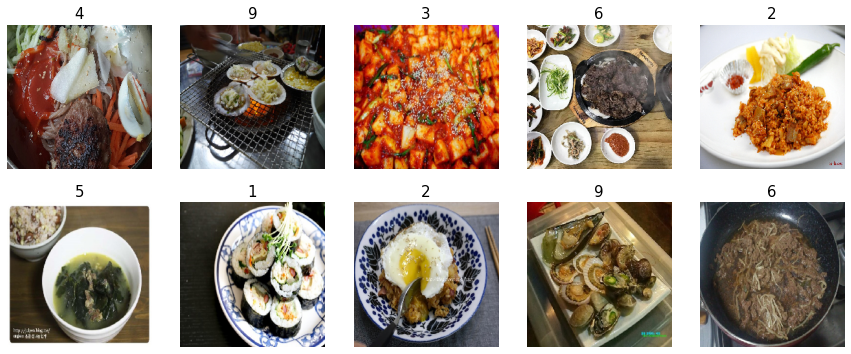

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

original_datagen = ImageDataGenerator(rescale=1./255)
original_generator = original_datagen.flow_from_directory(TRAIN_DIR, 
                                                          target_size=(224, 224), 
                                                          batch_size=32
                                                         )

for x, y in original_generator:
    print(x.shape, y.shape)
    print(y[0])
    
    fig, axes = plt.subplots(2, 5)
    fig.set_size_inches(15, 6)
    for i in range(10):
        axes[i//5, i%5].imshow(x[i])
        axes[i//5, i%5].set_title(f'{y[i].argmax()}', fontsize=15)
        axes[i//5, i%5].axis('off')
    break
plt.show()

## ↓↓↓ 코드 구현 ↓↓↓

### ImageDataGenerator

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
training_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest', 
    validation_split=0.2
)

In [ ]:
training_generator = training_datagen.flow_from_directory(TRAIN_DIR, 
                                                          batch_size=32, 
                                                          target_size=(224, 224), 
                                                          class_mode='categorical', 
                                                          subset='training',
                                                         )

Found 2800 images belonging to 10 classes.


In [ ]:
validation_generator = training_datagen.flow_from_directory(TRAIN_DIR, 
                                                            batch_size=32, 
                                                            target_size=(224, 224), 
                                                            class_mode='categorical',
                                                            subset='validation', 
                                                           )

Found 700 images belonging to 10 classes.


### 모델 정의 (Sequential)

In [ ]:
from tensorflow.keras.applications import VGG16, VGG19, ResNet50V2, ResNet101V2

In [ ]:
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
transfer_model.trainable=False

In [ ]:
transfer_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
transfer_model.trainable=False

94683136/94668760 [==============================] - 0s 0us/step


In [ ]:
transfer_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
transfer_model.trainable=False

171327488/171317808 [==============================] - 2s 0us/step


In [ ]:
model = Sequential([
    transfer_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(10, activation='softmax'),
])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_10 (Dense)            (None, 512)               51380736  
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 128)               65664     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 10)               

### 컴파일 (compile)

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['acc'])

### 학습 (fit)

- ModelCheckpoint 설정
- fit() 함수 구현
- checkpoint 로드

In [ ]:
checkpoint_path = "tmp_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [ ]:
model.fit(training_generator, 
          validation_data=(validation_generator),
          epochs=10,
          callbacks=[checkpoint],
          )

Epoch 1/10
88/88 [==============================] - ETA: 0s - loss: 0.4546 - acc: 0.8604
Epoch 1: val_loss did not improve from 0.51637
88/88 [==============================] - 56s 636ms/step - loss: 0.4546 - acc: 0.8604 - val_loss: 0.5465 - val_acc: 0.8400
Epoch 2/10
88/88 [==============================] - ETA: 0s - loss: 0.3598 - acc: 0.8814
Epoch 2: val_loss did not improve from 0.51637
88/88 [==============================] - 56s 636ms/step - loss: 0.3598 - acc: 0.8814 - val_loss: 0.5938 - val_acc: 0.8286
Epoch 3/10
88/88 [==============================] - ETA: 0s - loss: 0.3798 - acc: 0.8836
Epoch 3: val_loss improved from 0.51637 to 0.50287, saving model to tmp_checkpoint.ckpt
88/88 [==============================] - 58s 660ms/step - loss: 0.3798 - acc: 0.8836 - val_loss: 0.5029 - val_acc: 0.8443
Epoch 4/10
88/88 [==============================] - ETA: 0s - loss: 0.3277 - acc: 0.8975
Epoch 4: val_loss improved from 0.50287 to 0.47068, saving model to tmp_checkpoint.ckpt
88/88 [=

KeyboardInterrupt: ignored

In [ ]:
model.load_weights(checkpoint_path)

## URL로부터 예측

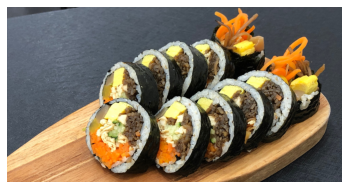

In [ ]:
from skimage import io

# 김밥 사진 URL
image_url = 'https://mp-seoul-image-production-s3.mangoplate.com/keyword_search/meta/pictures/oc1mqalnqarz3cwo.png'

# image 다운로드, 로드
image = io.imread(image_url)

# 시각화
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
image = image / 255.0
image = tf.image.resize(image, size=(224, 224))

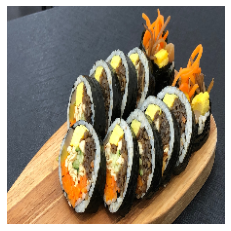

In [ ]:
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
food_list = {
    0: '고등어구이',
    1: '김밥',
    2: '김치볶음밥',
    3: '깍두기',
    4: '떡갈비',
    5: '미역국',
    6: '불고기',
    7: '삼겹살',
    8: '육개장',
    9: '조개구이',
}

In [ ]:
image.shape

TensorShape([224, 224, 3])

In [ ]:
tf.expand_dims(image, 0).shape

TensorShape([1, 224, 224, 3])

In [ ]:
image = tf.expand_dims(image, 0)
pred = model.predict(image)
result = pred.argmax(axis=1)
food_list[result[0]]

'김밥'

In [ ]:
def predict_image_from_url(url):
    # image 다운로드, 로드
    image = io.imread(url)

    # 시각화
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # 스케일, resize
    image = image / 255.0
    image = tf.image.resize(image, size=(224, 224))

    # 예측
    image = tf.expand_dims(image, 0)
    pred = model.predict(image)
    result = pred.argmax(axis=1)
    print(f'예측 결과: {food_list[result[0]]}, 확률: {pred.max() * 100:.2f}%')

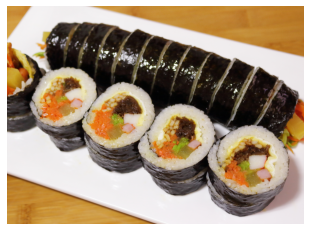

예측 결과: 김밥, 확률: 100.00%


In [ ]:
predict_image_from_url('https://homecuisine.co.kr/files/attach/images/140/001/083/558d170258752df2dd76bef00861497f.JPG')

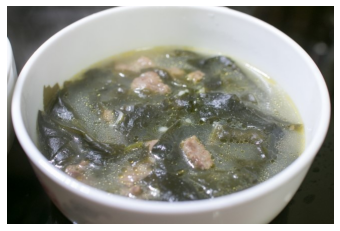

예측 결과: 미역국, 확률: 100.00%


In [ ]:
predict_image_from_url('https://recipe1.ezmember.co.kr/cache/recipe/2015/12/24/7b10402a82606a5a3de6710c93a110f41.jpg')

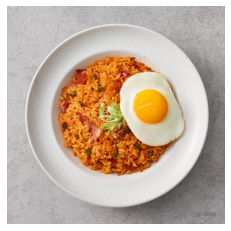

예측 결과: 김치볶음밥, 확률: 100.00%


In [ ]:
predict_image_from_url('https://www.cjthemarket.com/cjom/design/detail/prd_deatil_40063646_01.jpg')

## 예측 (코드 수정 금지)

In [ ]:
# 아래의 코드는 수정하지 않습니다.
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(TEST_DIR, 
                                                  target_size=(224, 224), 
                                                  batch_size=1,
                                                  shuffle=False                                                  
                                                  )

Found 1000 images belonging to 1 classes.


In [ ]:
# 아래의 코드는 수정하지 않습니다.
pred = model.predict(test_generator)
your_answer = pred.argmax(axis=1)

## 결과 제출

### 순서대로 평가가 진행됩니다. 실행은 1회만 해주세요.

- 느리다고 중지 후 다시 평가 코드를 실행하는 경우 제출 과정에서 패널티가 발생할 수 있습니다. (제출 횟수 이슈 발생 가능)

- 전체 점수는 [평가시스템](http://manage.jaen.kr)에서 확인할 수 있습니다.
    - 프로젝트 > 한국 음식 분류 > 리더보드 > 같은 반 리더보드

- 아이디: 본인 이메일 아이디
- 비번: 123123

아래 Cell을 실행하여 예측 결과 업데이트

In [ ]:
# 예측 결과 업데이트
submission = pd.read_csv(os.path.join('kfood', 'submission.csv'))
submission['label'] = your_answer
display(submission)

# 제출
project.email = email
project.submit(submission)

,image,label
0,test_0000.jpg,5
1,test_0001.jpg,0
2,test_0002.jpg,3
3,test_0003.jpg,8
4,test_0004.jpg,4
...,...,...
995,test_0995.jpg,1
996,test_0996.jpg,4
997,test_0997.jpg,3
998,test_0998.jpg,2


파일을 저장하였습니다. 파일명: submission-07-30-13.csv
제출 여부 :success
오늘 제출 횟수 : 7
제출 결과:0.841
